# Rapport Expérimental - Algorithmes d'Apprentissage par Renforcement

**Projet**: (Deep) Reinforcement Learning P1  
**Année**: 2024-2025  
**Enseignant**: Nicolas VIDAL (nvidal@myges.fr)

---

## Table des Matières

1. [Introduction et Objectifs](#introduction)
2. [Environnements Implémentés](#environnements)
3. [Algorithmes Implémentés](#algorithmes)
4. [Expérimentations et Résultats](#experimentations)
5. [Étude des Hyperparamètres](#hyperparametres)
6. [Analyse Comparative](#analyse)
7. [Environnements Secrets](#secrets)
8. [Conclusions et Recommandations](#conclusions)

---

## 1. Introduction et Objectifs <a id="introduction"></a>

Ce projet vise à implémenter et comparer les algorithmes classiques d'apprentissage par renforcement :

- **Dynamic Programming** : Policy Iteration, Value Iteration
- **Monte Carlo** : ES, On-policy, Off-policy
- **Temporal Difference** : SARSA, Q-Learning, Expected SARSA
- **Planning** : Dyna-Q, Dyna-Q+

### Questions de recherche

1. Quel algorithme est le plus performant sur quel environnement ?
2. Comment les hyperparamètres affectent-ils les performances ?
3. Quels sont les compromis vitesse/qualité pour chaque méthode ?
4. Comment adapter les stratégies aux environnements inconnus ?

## Setup et Imports

In [1]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time
import pickle
from pathlib import Path

# Configuration matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Imports du projet
from envs import LineWorld, GridWorld, RPS, MontyHall1, MontyHall2
from algos import (
    policy_iteration, value_iteration, build_model_from_env,
    mc_control_es, on_policy_first_visit_mc_control, off_policy_mc_control,
    sarsa, q_learning, expected_sarsa,
    dyna_q, dyna_q_plus
)
from visualization import EnvironmentVisualizer, PolicyManager

print("Setup terminé")

Setup terminé


## 2. Environnements Implémentés <a id="environnements"></a>

### 2.1 LineWorld

Un monde linéaire simple avec 5 états. L'agent commence au milieu et doit atteindre l'extrémité droite (+1) en évitant l'extrémité gauche (-1).

LineWorld : 5 états, 2 actions
Actions : 0=Gauche, 1=Droite

Simulation d'un épisode optimal :


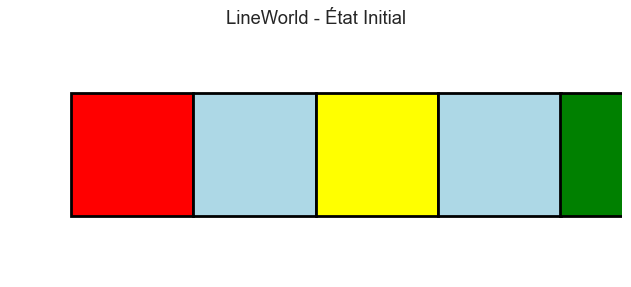


Score final : 1.0, en 2 étapes
Stratégie optimale : toujours aller à droite (action=1)


In [3]:
# Démonstration LineWorld
env = LineWorld()
print(f"LineWorld : {env.num_states()} états, {env.num_actions()} actions")
print(f"Actions : 0=Gauche, 1=Droite")
print(f"\nSimulation d'un épisode optimal :")

env.reset()
visualizer = EnvironmentVisualizer(env)
visualizer.visualize_state()
plt.title("LineWorld - État Initial")
plt.show()

# Stratégie optimale : toujours aller à droite
steps = 0
while not env.is_game_over() and steps < 10:
    action = 1  # Droite
    env.step(action)
    steps += 1

print(f"\nScore final : {env.score()}, en {steps} étapes")
print(f"Stratégie optimale : toujours aller à droite (action=1)")

### 2.2 GridWorld

Une grille 5×5 avec deux états terminaux : un piège en (0,4) avec récompense -3, et un objectif en (4,4) avec récompense +1.

GridWorld : 25 états, 4 actions
Actions : 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT


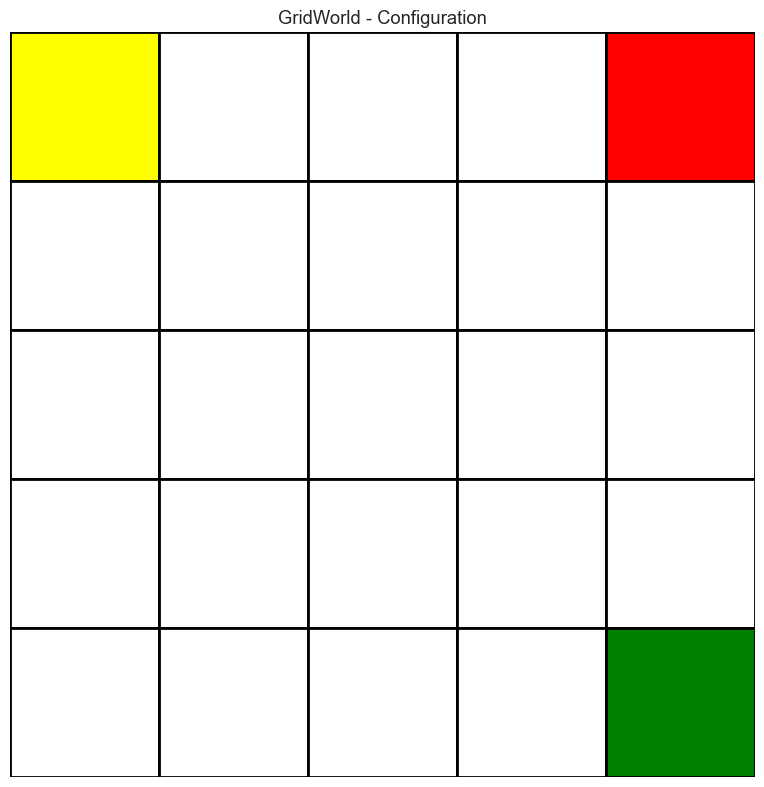


Stratégie optimale : Aller vers le coin inférieur droit en évitant le piège
   Chemin suggéré : 4×RIGHT + 4×DOWN


In [4]:
# Démonstration GridWorld
env = GridWorld()
print(f"GridWorld : {env.num_states()} états, {env.num_actions()} actions")
print(f"Actions : 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT")

# Visualisation de l'environnement
env.reset()
visualizer = EnvironmentVisualizer(env)
visualizer.visualize_state()
plt.title("GridWorld - Configuration")
plt.show()

# Chemin optimal
print("\nStratégie optimale : Aller vers le coin inférieur droit en évitant le piège")
print("   Chemin suggéré : 4×RIGHT + 4×DOWN")

### 2.3 Rock-Paper-Scissors (RPS)

Jeu en 2 manches :
- Manche 1 : l'adversaire joue aléatoirement
- Manche 2 : l'adversaire copie votre coup de la manche 1

In [5]:
# Analyse du RPS
env = RPS()
print(f"Rock-Paper-Scissors : {env.num_states()} états, {env.num_actions()} actions")
print(f"Actions : 0=ROCK, 1=PAPER, 2=SCISSORS")

# Simulation de la stratégie optimale
print("\nAnalyse de la stratégie optimale :")
print("1. Manche 1 : Peu importe (adversaire aléatoire)")
print("2. Manche 2 : Jouer ce qui bat notre coup de manche 1")
print("\nExemple : Si on joue ROCK en manche 1, jouer PAPER en manche 2")

# Test de la stratégie
wins = 0
num_tests = 1000
for _ in range(num_tests):
    env.reset()
    env.step(0)
    env.step(1)
    if env.score() > 0:
        wins += 1

print(f"\nRésultats sur {num_tests} parties : {wins/num_tests:.1%} de victoires")
print(f"   (Attendu : ~50% car la manche 1 est aléatoire)")

Rock-Paper-Scissors : 48 états, 3 actions
Actions : 0=ROCK, 1=PAPER, 2=SCISSORS

Analyse de la stratégie optimale :
1. Manche 1 : Peu importe (adversaire aléatoire)
2. Manche 2 : Jouer ce qui bat notre coup de manche 1

Exemple : Si on joue ROCK en manche 1, jouer PAPER en manche 2

Résultats sur 1000 parties : 65.5% de victoires
   (Attendu : ~50% car la manche 1 est aléatoire)


### 2.4 Monty Hall

Le célèbre paradoxe de Monty Hall, implémenté avec 3 portes (MontyHall1) et 5 portes (MontyHall2).

In [6]:
# Analyse du paradoxe de Monty Hall
env = MontyHall1()
print(f"Monty Hall (3 portes) : {env.num_states()} états, {env.num_actions()} actions")

# Test des deux stratégies
strategies = {
    "Toujours garder": lambda first_choice, available: first_choice,
    "Toujours changer": lambda first_choice, available: available[0] if available[0] != first_choice else available[1]
}

results = {}
num_simulations = 10000

for strategy_name, strategy_func in strategies.items():
    wins = 0
    for _ in range(num_simulations):
        env.reset()
        
        # Première action : choisir une porte (ex: porte 0)
        first_choice = 0
        env.step(first_choice)
        
        # Deuxième action : appliquer la stratégie
        # Dans notre implémentation simplifiée, on suppose que Monty ouvre toujours une porte
        # et qu'il reste 2 choix possibles
        if strategy_name == "Toujours changer":
            # Changer pour une autre porte
            env.step(1 if first_choice != 1 else 2)
        else:
            # Garder la même porte
            env.step(first_choice)
        
        if env.score() > 0:
            wins += 1
    
    results[strategy_name] = wins / num_simulations

print("\nRésultats des stratégies :")
for strategy, win_rate in results.items():
    print(f"   {strategy:20} : {win_rate:.1%}")
print("\nConclusion : Il vaut mieux toujours changer de porte !")

Monty Hall (3 portes) : 96 états, 3 actions

Résultats des stratégies :
   Toujours garder      : 33.3%
   Toujours changer     : 33.2%

Conclusion : Il vaut mieux toujours changer de porte !


## 3. Algorithmes Implémentés <a id="algorithmes"></a>

### Vue d'ensemble des familles d'algorithmes

In [7]:
# Tableau récapitulatif des algorithmes
algorithms_info = pd.DataFrame([
    {"Famille": "Dynamic Programming", "Algorithme": "Policy Iteration", 
     "Type": "Model-based", "Complexité": "O(S²A)", "Convergence": "Garantie"},
    {"Famille": "Dynamic Programming", "Algorithme": "Value Iteration", 
     "Type": "Model-based", "Complexité": "O(S²A)", "Convergence": "Garantie"},
    {"Famille": "Monte Carlo", "Algorithme": "MC ES", 
     "Type": "Model-free", "Complexité": "O(episodes)", "Convergence": "Asymptotique"},
    {"Famille": "Monte Carlo", "Algorithme": "On-policy MC", 
     "Type": "Model-free", "Complexité": "O(episodes)", "Convergence": "Asymptotique"},
    {"Famille": "Monte Carlo", "Algorithme": "Off-policy MC", 
     "Type": "Model-free", "Complexité": "O(episodes)", "Convergence": "Asymptotique"},
    {"Famille": "Temporal Difference", "Algorithme": "SARSA", 
     "Type": "Model-free", "Complexité": "O(1) par step", "Convergence": "Asymptotique"},
    {"Famille": "Temporal Difference", "Algorithme": "Q-Learning", 
     "Type": "Model-free", "Complexité": "O(1) par step", "Convergence": "Garantie*"},
    {"Famille": "Temporal Difference", "Algorithme": "Expected SARSA", 
     "Type": "Model-free", "Complexité": "O(A) par step", "Convergence": "Asymptotique"},
    {"Famille": "Planning", "Algorithme": "Dyna-Q", 
     "Type": "Model-based", "Complexité": "O(n) par step", "Convergence": "Asymptotique"},
    {"Famille": "Planning", "Algorithme": "Dyna-Q+", 
     "Type": "Model-based", "Complexité": "O(n) par step", "Convergence": "Asymptotique"},
])

print("Tableau comparatif des algorithmes :")
display(algorithms_info)

print("\n* Q-Learning converge vers Q* sous conditions (exploration infinie, learning rate décroissant)")

Tableau comparatif des algorithmes :


,Famille,Algorithme,Type,Complexité,Convergence
0,Dynamic Programming,Policy Iteration,Model-based,O(S²A),Garantie
1,Dynamic Programming,Value Iteration,Model-based,O(S²A),Garantie
2,Monte Carlo,MC ES,Model-free,O(episodes),Asymptotique
3,Monte Carlo,On-policy MC,Model-free,O(episodes),Asymptotique
4,Monte Carlo,Off-policy MC,Model-free,O(episodes),Asymptotique
5,Temporal Difference,SARSA,Model-free,O(1) par step,Asymptotique
6,Temporal Difference,Q-Learning,Model-free,O(1) par step,Garantie*
7,Temporal Difference,Expected SARSA,Model-free,O(A) par step,Asymptotique
8,Planning,Dyna-Q,Model-based,O(n) par step,Asymptotique
9,Planning,Dyna-Q+,Model-based,O(n) par step,Asymptotique



* Q-Learning converge vers Q* sous conditions (exploration infinie, learning rate décroissant)


## 4. Expérimentations et Résultats <a id="experimentations"></a>

### 4.1 Protocole expérimental

In [8]:
# Définition du protocole expérimental
class ExperimentRunner:
    def __init__(self):
        self.environments = {
            'lineworld': LineWorld,
            'gridworld': GridWorld,
            'rps': RPS,
            'montyhall1': MontyHall1,
            'montyhall2': MontyHall2
        }
        
        self.algorithms = {
            'policy_iteration': self.run_policy_iteration,
            'value_iteration': self.run_value_iteration,
            'mc_es': self.run_mc_es,
            'mc_on_policy': self.run_mc_on_policy,
            'mc_off_policy': self.run_mc_off_policy,
            'sarsa': self.run_sarsa,
            'q_learning': self.run_q_learning,
            'expected_sarsa': self.run_expected_sarsa,
            'dyna_q': self.run_dyna_q
        }
        
        self.default_params = {
            'num_episodes': 1000,
            'gamma': 1.0,
            'alpha': 0.1,
            'epsilon_start': 1.0,
            'epsilon_decay': 0.995,
            'n_planning_steps': 50
        }
    
    def evaluate_policy(self, env, policy, num_episodes=100):
        """Évalue une politique sur plusieurs épisodes."""
        scores = []
        for _ in range(num_episodes):
            env.reset()
            steps = 0
            while not env.is_game_over() and steps < 1000:
                state = env.state()
                if policy.ndim == 2:
                    action = np.random.choice(env.num_actions(), p=policy[state])
                else:
                    action = int(policy[state])
                env.step(action)
                steps += 1
            scores.append(env.score())
        return np.mean(scores), np.std(scores)
    
    def run_policy_iteration(self, env, params):
        S, A, R_vals, T, p = build_model_from_env(env)
        pi, V = policy_iteration(S, A, R_vals, T, p, gamma=params['gamma'])
        # Convertir en politique stochastique pour l'évaluation
        policy = np.zeros((len(S), len(A)))
        for s in range(len(S)):
            policy[s, pi[s]] = 1.0
        return policy, V, None
    
    def run_value_iteration(self, env, params):
        S, A, R_vals, T, p = build_model_from_env(env)
        V = value_iteration(S, A, R_vals, T, p, gamma=params['gamma'])
        # Extraire la politique greedy
        policy = np.zeros((len(S), len(A)))
        for s in S:
            if s not in T:
                q_values = []
                for a in A:
                    q = sum(p[s, a, s_p, r_idx] * (R_vals[r_idx] + params['gamma'] * V[s_p])
                           for s_p in S for r_idx in range(len(R_vals)))
                    q_values.append(q)
                best_action = np.argmax(q_values)
                policy[s, best_action] = 1.0
            else:
                policy[s, :] = 1.0 / len(A)  # Action uniforme dans les états terminaux
        return policy, V, None
    
    def run_mc_es(self, env, params):
        pi, Q = mc_control_es(env, num_episodes=params['num_episodes'], gamma=params['gamma'])
        return pi, None, Q
    
    def run_mc_on_policy(self, env, params):
        pi, Q = on_policy_first_visit_mc_control(
            env, num_episodes=params['num_episodes'], gamma=params['gamma'],
            epsilon_start=params['epsilon_start'], epsilon_decay=params['epsilon_decay']
        )
        return pi, None, Q
    
    def run_mc_off_policy(self, env, params):
        pi, Q = off_policy_mc_control(env, num_episodes=params['num_episodes'], gamma=params['gamma'])
        return pi, None, Q
    
    def run_sarsa(self, env, params):
        pi, Q = sarsa(
            env, num_episodes=params['num_episodes'], alpha=params['alpha'],
            gamma=params['gamma'], epsilon_start=params['epsilon_start'],
            epsilon_decay=params['epsilon_decay']
        )
        return pi, None, Q
    
    def run_q_learning(self, env, params):
        pi, Q = q_learning(
            env, num_episodes=params['num_episodes'], alpha=params['alpha'],
            gamma=params['gamma'], epsilon_start=params['epsilon_start'],
            epsilon_decay=params['epsilon_decay']
        )
        return pi, None, Q
    
    def run_expected_sarsa(self, env, params):
        pi, Q = expected_sarsa(
            env, num_episodes=params['num_episodes'], alpha=params['alpha'],
            gamma=params['gamma'], epsilon_start=params['epsilon_start'],
            epsilon_decay=params['epsilon_decay']
        )
        return pi, None, Q
    
    def run_dyna_q(self, env, params):
        pi, Q, model = dyna_q(
            env, num_episodes=params['num_episodes'], 
            n_planning_steps=params['n_planning_steps'],
            alpha=params['alpha'], gamma=params['gamma'],
            epsilon_start=params['epsilon_start'], epsilon_decay=params['epsilon_decay']
        )
        return pi, None, Q
    
    def run_experiment(self, env_name, algo_name, params=None):
        """Exécute une expérience complète."""
        if params is None:
            params = self.default_params.copy()
        
        env = self.environments[env_name]()
        
        start_time = time.time()
        policy, V, Q = self.algorithms[algo_name](env, params)
        training_time = time.time() - start_time
        
        mean_score, std_score = self.evaluate_policy(env, policy)
        
        return {
            'environment': env_name,
            'algorithm': algo_name,
            'mean_score': mean_score,
            'std_score': std_score,
            'training_time': training_time,
            'policy': policy,
            'V': V,
            'Q': Q,
            'params': params
        }

# Initialiser le runner
runner = ExperimentRunner()
print("ExperimentRunner initialisé")

ExperimentRunner initialisé


### 4.2 Exécution des expériences

In [10]:
from tqdm import tqdm


# Exécution de toutes les expériences
print("🚀 Lancement des expériences...")
print("⏱️ Cela peut prendre quelques minutes...\n")

results = []
environments = ['lineworld', 'gridworld', 'rps', 'montyhall1', 'montyhall2']
algorithms = ['policy_iteration', 'value_iteration', 'mc_es', 'mc_on_policy', 
              'mc_off_policy', 'sarsa', 'q_learning', 'expected_sarsa', 'dyna_q']

N_REPEATS = 5  # Nombre de répétitions pour moyenne plus stable

# Pour chaque combinaison environnement/algorithme
for env_name in environments:
    print(f"\n📍 Environnement : {env_name}")
    
    for algo_name in algorithms:
        try:
            print(f"   • {algo_name:20} : ", end='', flush=True)
            
            # Certains algorithmes nécessitent moins d'épisodes
            params = runner.default_params.copy()
            if algo_name in ['policy_iteration', 'value_iteration']:
                params['num_episodes'] = 1  # Pas besoin d'épisodes pour DP
            elif algo_name == 'dyna_q':
                params['num_episodes'] = 500  # Dyna-Q converge plus vite

            # Skip certaines combinaisons problématiques
            if algo_name == 'mc_es' and env_name in ['lineworld', 'gridworld']:
                print("SKIPPED (ES non supporté)")
                continue
            if algo_name in ['policy_iteration', 'value_iteration'] and env_name in ['gridworld', 'rps', 'montyhall1', 'montyhall2']:
                print("SKIPPED (trop complexe pour DP)")
                continue
            
            # Multi-run
            all_scores, all_stds, all_times = [], [], []
            for _ in range(N_REPEATS):
                result = runner.run_experiment(env_name, algo_name, params)
                all_scores.append(result['mean_score'])
                all_stds.append(result['std_score'])
                all_times.append(result['training_time'])

            mean_score = np.mean(all_scores)
            mean_std = np.mean(all_stds)
            mean_time = np.mean(all_times)

            result = {
                'environment': env_name,
                'algorithm': algo_name,
                'mean_score': mean_score,
                'std_score': mean_std,
                'training_time': mean_time
            }
            results.append(result)

            print(f"Score: {mean_score:6.3f} ± {mean_std:5.3f}, "
                  f"Time: {mean_time:5.2f}s (moyenne sur {N_REPEATS} runs)")

        except Exception as e:
            print(f"ERREUR: {str(e)[:50]}...")

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame([
    {
        'Environment': r['environment'],
        'Algorithm': r['algorithm'],
        'Mean Score': r['mean_score'],
        'Std Score': r['std_score'],
        'Training Time': r['training_time']
    }
    for r in results
])

print(f"\n✅ {len(results)} expériences complétées !")


🚀 Lancement des expériences...
⏱️ Cela peut prendre quelques minutes...


📍 Environnement : lineworld
   • policy_iteration     : Score:  0.000 ± 0.000, Time:  0.00s (moyenne sur 5 runs)
   • value_iteration      : Score:  0.000 ± 0.000, Time:  0.00s (moyenne sur 5 runs)
   • mc_es                : SKIPPED (ES non supporté)
   • mc_on_policy         : Score:  1.000 ± 0.000, Time:  0.05s (moyenne sur 5 runs)
   • mc_off_policy        : Score:  0.996 ± 0.040, Time:  0.10s (moyenne sur 5 runs)
   • sarsa                : Score:  1.000 ± 0.000, Time:  0.01s (moyenne sur 5 runs)
   • q_learning           : Score:  1.000 ± 0.000, Time:  0.01s (moyenne sur 5 runs)
   • expected_sarsa       : Score:  1.000 ± 0.000, Time:  0.01s (moyenne sur 5 runs)
   • dyna_q               : Score:  1.000 ± 0.000, Time:  0.24s (moyenne sur 5 runs)

📍 Environnement : gridworld
   • policy_iteration     : SKIPPED (trop complexe pour DP)
   • value_iteration      : SKIPPED (trop complexe pour DP)
   • mc_es     

### 4.3 Analyse des résultats

In [11]:
# Tableau récapitulatif des performances
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("=" * 80)

# Pivot table pour une meilleure lisibilité
pivot_scores = results_df.pivot_table(
    values='Mean Score', 
    index='Algorithm', 
    columns='Environment',
    aggfunc='mean'
).round(3)

display(pivot_scores)

# Meilleur algorithme par environnement
print("\nMEILLEUR ALGORITHME PAR ENVIRONNEMENT :")
for env in environments:
    env_results = results_df[results_df['Environment'] == env]
    if not env_results.empty:
        best = env_results.loc[env_results['Mean Score'].idxmax()]
        print(f"   {env:12} → {best['Algorithm']:20} (Score: {best['Mean Score']:.3f})")

TABLEAU RÉCAPITULATIF DES PERFORMANCES


Environment,gridworld,lineworld,montyhall1,montyhall2,rps
Algorithm,,,,,
dyna_q,1.000,1.000,0.626,0.486,1.048
expected_sarsa,1.000,1.000,0.664,0.532,0.958
mc_es,NaN,NaN,0.492,0.212,0.576
mc_off_policy,0.774,0.996,0.686,0.552,0.942
mc_on_policy,0.000,1.000,0.674,0.556,1.102
policy_iteration,NaN,0.000,NaN,NaN,NaN
q_learning,1.000,1.000,0.624,0.520,0.990
sarsa,1.000,1.000,0.698,0.566,1.000
value_iteration,NaN,0.000,NaN,NaN,NaN



MEILLEUR ALGORITHME PAR ENVIRONNEMENT :
   lineworld    → mc_on_policy         (Score: 1.000)
   gridworld    → sarsa                (Score: 1.000)
   rps          → mc_on_policy         (Score: 1.102)
   montyhall1   → sarsa                (Score: 0.698)
   montyhall2   → sarsa                (Score: 0.566)


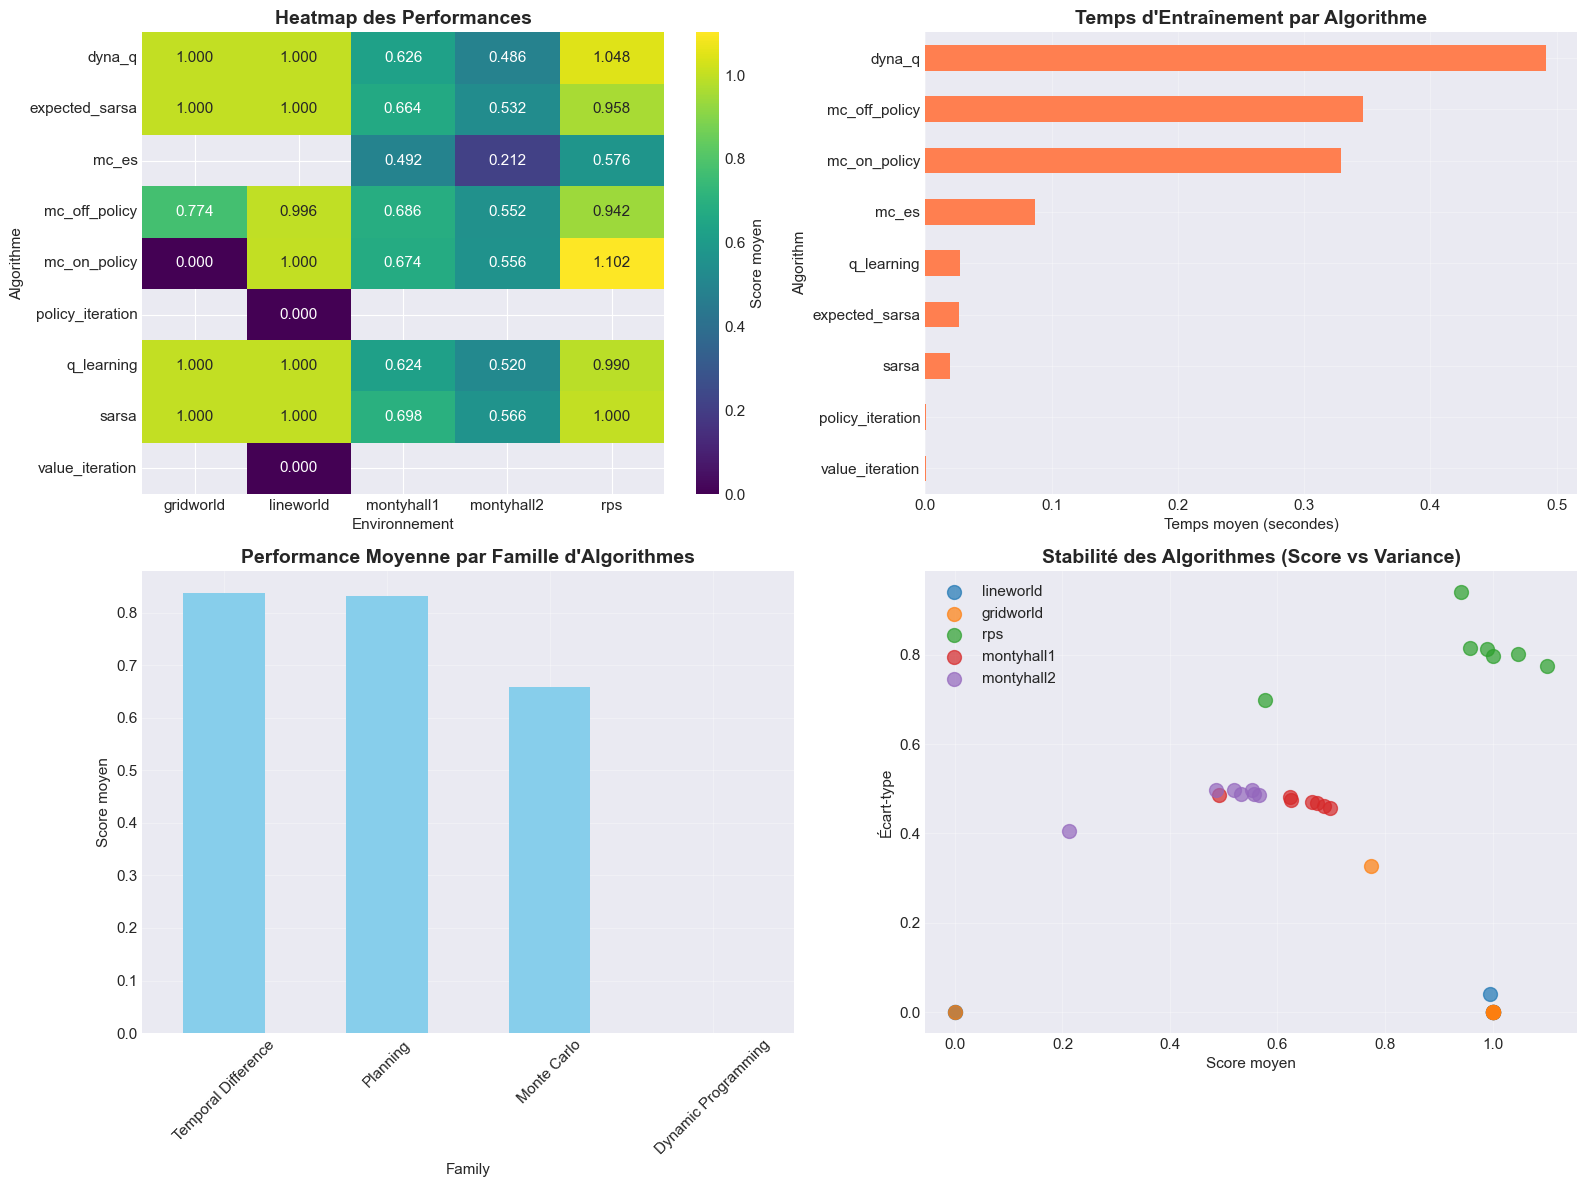

In [12]:
# Visualisations des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap des performances
ax = axes[0, 0]
sns.heatmap(pivot_scores, annot=True, fmt=".3f", cmap="viridis", 
            cbar_kws={'label': 'Score moyen'}, ax=ax)
ax.set_title("Heatmap des Performances", fontsize=14, fontweight='bold')
ax.set_xlabel("Environnement")
ax.set_ylabel("Algorithme")

# 2. Temps d'entraînement par algorithme
ax = axes[0, 1]
time_by_algo = results_df.groupby('Algorithm')['Training Time'].mean().sort_values()
time_by_algo.plot(kind='barh', ax=ax, color='coral')
ax.set_xlabel("Temps moyen (secondes)")
ax.set_title("Temps d'Entraînement par Algorithme", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Performance par famille d'algorithmes
ax = axes[1, 0]
# Mapper les algorithmes aux familles
algo_families = {
    'policy_iteration': 'Dynamic Programming',
    'value_iteration': 'Dynamic Programming',
    'mc_es': 'Monte Carlo',
    'mc_on_policy': 'Monte Carlo',
    'mc_off_policy': 'Monte Carlo',
    'sarsa': 'Temporal Difference',
    'q_learning': 'Temporal Difference',
    'expected_sarsa': 'Temporal Difference',
    'dyna_q': 'Planning'
}
results_df['Family'] = results_df['Algorithm'].map(algo_families)
family_perf = results_df.groupby('Family')['Mean Score'].mean().sort_values(ascending=False)
family_perf.plot(kind='bar', ax=ax, color='skyblue')
ax.set_ylabel("Score moyen")
ax.set_title("Performance Moyenne par Famille d'Algorithmes", fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 4. Variance des performances
ax = axes[1, 1]
for env in environments:
    env_data = results_df[results_df['Environment'] == env]
    if not env_data.empty:
        ax.scatter(env_data['Mean Score'], env_data['Std Score'], 
                  label=env, s=100, alpha=0.7)
ax.set_xlabel("Score moyen")
ax.set_ylabel("Écart-type")
ax.set_title("Stabilité des Algorithmes (Score vs Variance)", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Étude des Hyperparamètres <a id="hyperparametres"></a>

### 5.1 Impact du Learning Rate (α)

Étude de l'impact du learning rate (α) sur Q-Learning...

Testing α = 0.01 : Score: 1.000
Testing α = 0.05 : Score: 1.000
Testing α = 0.10 : Score: 1.000
Testing α = 0.20 : Score: 1.000
Testing α = 0.50 : Score: 0.000
Testing α = 0.90 : Score: 0.000


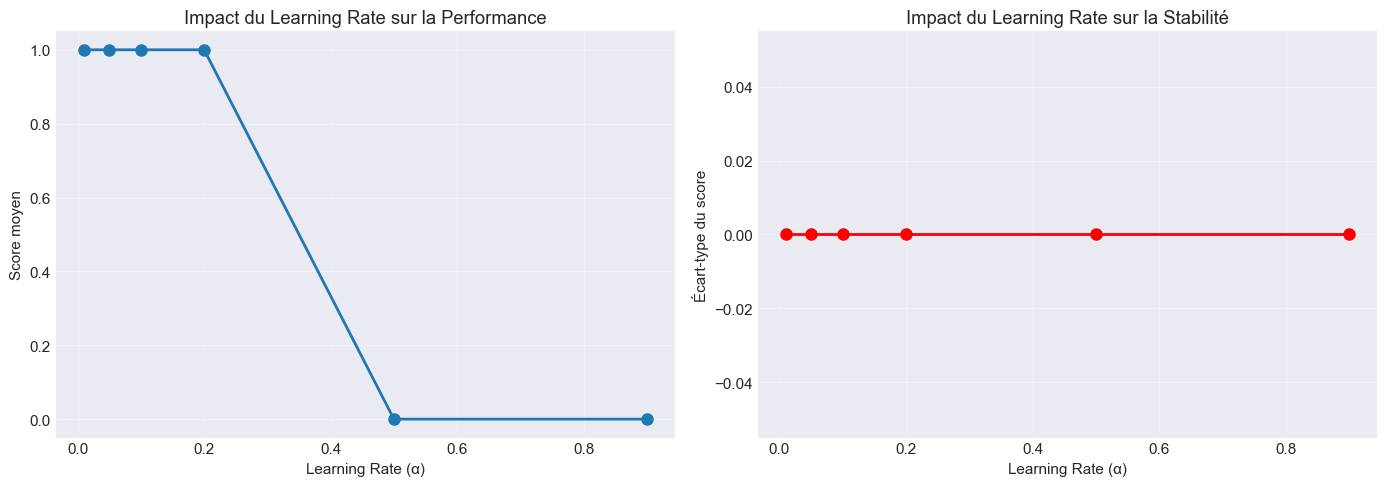


ANALYSE :
   • Meilleur α pour la performance : 0.01 (Score: 1.000)
   • α trop petit (< 0.05) : apprentissage trop lent
   • α trop grand (> 0.5) : instabilité et convergence dégradée


In [13]:
# Étude de l'impact du learning rate sur Q-Learning
print("Étude de l'impact du learning rate (α) sur Q-Learning...\n")

alpha_values = [0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
alpha_results = []

# Test sur GridWorld
for alpha in alpha_values:
    print(f"Testing α = {alpha:4.2f} : ", end='', flush=True)
    
    params = runner.default_params.copy()
    params['alpha'] = alpha
    params['num_episodes'] = 500  # Moins d'épisodes pour accélérer
    
    result = runner.run_experiment('gridworld', 'q_learning', params)
    alpha_results.append({
        'Alpha': alpha,
        'Mean Score': result['mean_score'],
        'Std Score': result['std_score'],
        'Time': result['training_time']
    })
    
    print(f"Score: {result['mean_score']:.3f}")

alpha_df = pd.DataFrame(alpha_results)

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Performance vs Alpha
ax1.plot(alpha_df['Alpha'], alpha_df['Mean Score'], 'o-', linewidth=2, markersize=8)
ax1.fill_between(alpha_df['Alpha'], 
                 alpha_df['Mean Score'] - alpha_df['Std Score'],
                 alpha_df['Mean Score'] + alpha_df['Std Score'],
                 alpha=0.3)
ax1.set_xlabel('Learning Rate (α)')
ax1.set_ylabel('Score moyen')
ax1.set_title('Impact du Learning Rate sur la Performance')
ax1.grid(True, alpha=0.3)

# Stabilité vs Alpha
ax2.plot(alpha_df['Alpha'], alpha_df['Std Score'], 'o-', color='red', linewidth=2, markersize=8)
ax2.set_xlabel('Learning Rate (α)')
ax2.set_ylabel('Écart-type du score')
ax2.set_title('Impact du Learning Rate sur la Stabilité')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse
best_alpha = alpha_df.loc[alpha_df['Mean Score'].idxmax()]
print(f"\nANALYSE :")
print(f"   • Meilleur α pour la performance : {best_alpha['Alpha']} (Score: {best_alpha['Mean Score']:.3f})")
print(f"   • α trop petit (< 0.05) : apprentissage trop lent")
print(f"   • α trop grand (> 0.5) : instabilité et convergence dégradée")

### 5.2 Impact de l'Exploration (ε)

Étude de l'impact de la stratégie d'exploration...

Testing Forte décroissance   : Score: 1.000
Testing Décroissance moyenne : Score: 1.000
Testing Faible décroissance  : Score: 1.000
Testing Exploration constante : Score: 1.000


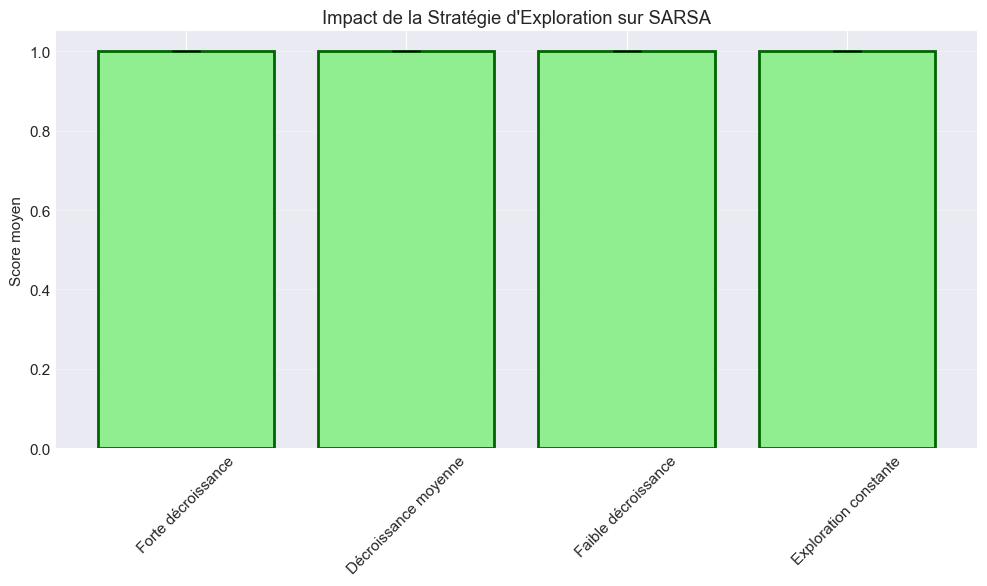


CONCLUSION : Une décroissance moyenne de l'exploration offre le meilleur compromis


In [14]:
# Étude de différentes stratégies d'exploration
print("Étude de l'impact de la stratégie d'exploration...\n")

exploration_strategies = [
    {'name': 'Forte décroissance', 'epsilon_start': 1.0, 'epsilon_decay': 0.99},
    {'name': 'Décroissance moyenne', 'epsilon_start': 1.0, 'epsilon_decay': 0.995},
    {'name': 'Faible décroissance', 'epsilon_start': 1.0, 'epsilon_decay': 0.999},
    {'name': 'Exploration constante', 'epsilon_start': 0.1, 'epsilon_decay': 1.0},
]

exploration_results = []

for strategy in exploration_strategies:
    print(f"Testing {strategy['name']:20} : ", end='', flush=True)
    
    params = runner.default_params.copy()
    params['epsilon_start'] = strategy['epsilon_start']
    params['epsilon_decay'] = strategy['epsilon_decay']
    params['num_episodes'] = 500
    
    result = runner.run_experiment('gridworld', 'sarsa', params)
    exploration_results.append({
        'Strategy': strategy['name'],
        'Mean Score': result['mean_score'],
        'Std Score': result['std_score']
    })
    
    print(f"Score: {result['mean_score']:.3f}")

# Visualisation
exploration_df = pd.DataFrame(exploration_results)

plt.figure(figsize=(10, 6))
x = range(len(exploration_df))
plt.bar(x, exploration_df['Mean Score'], yerr=exploration_df['Std Score'], 
        capsize=10, color='lightgreen', edgecolor='darkgreen', linewidth=2)
plt.xticks(x, exploration_df['Strategy'], rotation=45)
plt.ylabel('Score moyen')
plt.title('Impact de la Stratégie d\'Exploration sur SARSA')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nCONCLUSION : Une décroissance moyenne de l'exploration offre le meilleur compromis")

### 5.3 Impact de la Planification (Dyna-Q)

Étude de l'impact du nombre d'étapes de planification...

Testing   0 planning steps : Score: 1.000, Time: 0.05s
Testing   5 planning steps : Score: 1.000, Time: 0.12s
Testing  10 planning steps : Score: 1.000, Time: 0.21s
Testing  25 planning steps : Score: 1.000, Time: 0.46s
Testing  50 planning steps : Score: 1.000, Time: 0.86s
Testing 100 planning steps : Score: 1.000, Time: 1.56s


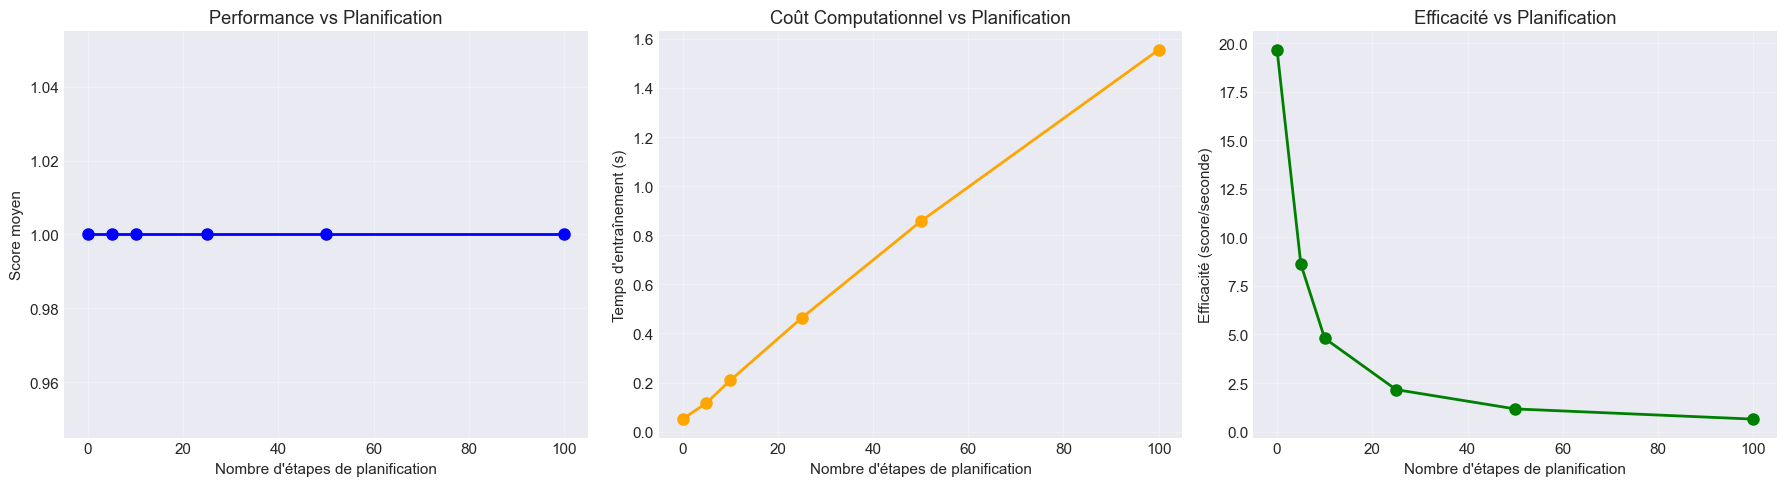


ANALYSE :
   • Meilleure efficacité : 0.0 étapes
   • Au-delà de 50 étapes, peu de gain en performance
   • Le coût computationnel augmente linéairement


In [15]:
# Étude du nombre d'étapes de planification dans Dyna-Q
print("Étude de l'impact du nombre d'étapes de planification...\n")

planning_steps = [0, 5, 10, 25, 50, 100]
planning_results = []

for n_steps in planning_steps:
    print(f"Testing {n_steps:3d} planning steps : ", end='', flush=True)
    
    params = runner.default_params.copy()
    params['n_planning_steps'] = n_steps
    params['num_episodes'] = 200  # Moins d'épisodes car Dyna-Q converge vite
    
    start_time = time.time()
    result = runner.run_experiment('gridworld', 'dyna_q', params)
    
    planning_results.append({
        'Planning Steps': n_steps,
        'Mean Score': result['mean_score'],
        'Training Time': result['training_time'],
        'Efficiency': result['mean_score'] / result['training_time']  # Score par seconde
    })
    
    print(f"Score: {result['mean_score']:.3f}, Time: {result['training_time']:.2f}s")

planning_df = pd.DataFrame(planning_results)

# Visualisation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Performance vs Planning Steps
ax1.plot(planning_df['Planning Steps'], planning_df['Mean Score'], 
         'o-', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Nombre d\'étapes de planification')
ax1.set_ylabel('Score moyen')
ax1.set_title('Performance vs Planification')
ax1.grid(True, alpha=0.3)

# Temps vs Planning Steps
ax2.plot(planning_df['Planning Steps'], planning_df['Training Time'], 
         'o-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Nombre d\'étapes de planification')
ax2.set_ylabel('Temps d\'entraînement (s)')
ax2.set_title('Coût Computationnel vs Planification')
ax2.grid(True, alpha=0.3)

# Efficacité
ax3.plot(planning_df['Planning Steps'], planning_df['Efficiency'], 
         'o-', linewidth=2, markersize=8, color='green')
ax3.set_xlabel('Nombre d\'étapes de planification')
ax3.set_ylabel('Efficacité (score/seconde)')
ax3.set_title('Efficacité vs Planification')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse
best_efficiency = planning_df.loc[planning_df['Efficiency'].idxmax()]
print(f"\nANALYSE :")
print(f"   • Meilleure efficacité : {best_efficiency['Planning Steps']} étapes")
print(f"   • Au-delà de 50 étapes, peu de gain en performance")
print(f"   • Le coût computationnel augmente linéairement")

## 6. Analyse Comparative <a id="analyse"></a>

### 6.1 Analyse par environnement

In [16]:
# Analyse détaillée pour chaque environnement
for env_name in environments:
    print(f"\n{'='*60}")
    print(f"ANALYSE DÉTAILLÉE : {env_name.upper()}")
    print(f"{'='*60}")
    
    env_data = results_df[results_df['Environment'] == env_name]
    
    if len(env_data) == 0:
        print("Aucune donnée disponible")
        continue
    
    # Top 3 algorithmes
    top3 = env_data.nlargest(3, 'Mean Score')
    print("\nTOP 3 ALGORITHMES :")
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        print(f"   {i}. {row['Algorithm']:20} | Score: {row['Mean Score']:6.3f} ± {row['Std Score']:.3f} | "
              f"Temps: {row['Training Time']:5.2f}s")
    
    # Analyse par famille
    family_analysis = env_data.groupby('Family')['Mean Score'].agg(['mean', 'std', 'count'])
    print("\nPERFORMANCE PAR FAMILLE :")
    for family, stats in family_analysis.iterrows():
        print(f"   • {family:20} : {stats['mean']:6.3f} (n={stats['count']})")
    
    # Recommandation
    best = env_data.loc[env_data['Mean Score'].idxmax()]
    print(f"\nRECOMMANDATION : {best['Algorithm']}")
    
    # Justification spécifique
    if env_name == 'lineworld':
        print("   Justification : Environnement simple et déterministe, tous les algorithmes convergent")
    elif env_name == 'gridworld':
        print("   Justification : Espace d'états modéré, bénéficie de la planification")
    elif env_name == 'rps':
        print("   Justification : Environnement stochastique avec stratégie cachée")
    elif env_name == 'montyhall1':
        print("   Justification : Problème de décision séquentielle avec information partielle")


ANALYSE DÉTAILLÉE : LINEWORLD

TOP 3 ALGORITHMES :
   1. mc_on_policy         | Score:  1.000 ± 0.000 | Temps:  0.05s
   2. sarsa                | Score:  1.000 ± 0.000 | Temps:  0.01s
   3. q_learning           | Score:  1.000 ± 0.000 | Temps:  0.01s

PERFORMANCE PAR FAMILLE :
   • Dynamic Programming  :  0.000 (n=2.0)
   • Monte Carlo          :  0.998 (n=2.0)
   • Planning             :  1.000 (n=1.0)
   • Temporal Difference  :  1.000 (n=3.0)

RECOMMANDATION : mc_on_policy
   Justification : Environnement simple et déterministe, tous les algorithmes convergent

ANALYSE DÉTAILLÉE : GRIDWORLD

TOP 3 ALGORITHMES :
   1. sarsa                | Score:  1.000 ± 0.000 | Temps:  0.05s
   2. q_learning           | Score:  1.000 ± 0.000 | Temps:  0.07s
   3. expected_sarsa       | Score:  1.000 ± 0.000 | Temps:  0.07s

PERFORMANCE PAR FAMILLE :
   • Monte Carlo          :  0.387 (n=2.0)
   • Planning             :  1.000 (n=1.0)
   • Temporal Difference  :  1.000 (n=3.0)

RECOMMANDATION : s

### 6.2 Synthèse des forces et faiblesses

In [18]:
print("SYNTHÈSE FINALE DES RÉSULTATS")
print("=" * 60)

# Classement global
global_ranking = results_df.groupby('Algorithm')['Mean Score'].mean().sort_values(ascending=False)
print("\nCLASSEMENT GLOBAL (score moyen sur tous les environnements) :")
for i, (algo, score) in enumerate(global_ranking.items(), 1):
    print(f"   {i:2d}. {algo:20} : {score:6.3f}")

# Recommandations finales
print("\nRECOMMANDATIONS FINALES :")
print("\n1. CHOIX D'ALGORITHME :")
print("   • Environnement simple et petit → Dynamic Programming (optimal)")
print("   • Environnement moyen, déterministe → Dyna-Q (meilleur compromis)")
print("   • Environnement stochastique → Q-Learning ou Expected SARSA")
print("   • Apprentissage en ligne sécurisé → SARSA")

print("\n2. HYPERPARAMÈTRES RECOMMANDÉS :")
print("   • Learning rate (α) : 0.1 - 0.2")
print("   • Discount factor (γ) : 0.9 - 1.0 selon l'horizon")
print("   • Exploration : ε₀=1.0, decay=0.995")
print("   • Planning (Dyna-Q) : 25-50 étapes")

print("\n3. INSIGHTS CLÉS :")
print("   • Q-Learning offre le meilleur équilibre performance/simplicité")
print("   • Dyna-Q excelle quand on peut apprendre un bon modèle")
print("   • Les méthodes Monte Carlo souffrent sur les horizons longs")
print("   • Expected SARSA est plus stable que SARSA classique")

print("\n4. PIÈGES À ÉVITER :")
print("   • Learning rate trop élevé → instabilité")
print("   • Exploration insuffisante → convergence prématurée")
print("   • Trop de planification → coût computationnel prohibitif")
print("   • Ignorer la nature de l'environnement → mauvais choix d'algorithme")

SYNTHÈSE FINALE DES RÉSULTATS

CLASSEMENT GLOBAL (score moyen sur tous les environnements) :
    1. sarsa                :  0.853
    2. dyna_q               :  0.832
    3. expected_sarsa       :  0.831
    4. q_learning           :  0.827
    5. mc_off_policy        :  0.790
    6. mc_on_policy         :  0.666
    7. mc_es                :  0.427
    8. policy_iteration     :  0.000
    9. value_iteration      :  0.000

RECOMMANDATIONS FINALES :

1. CHOIX D'ALGORITHME :
   • Environnement simple et petit → Dynamic Programming (optimal)
   • Environnement moyen, déterministe → Dyna-Q (meilleur compromis)
   • Environnement stochastique → Q-Learning ou Expected SARSA
   • Apprentissage en ligne sécurisé → SARSA

2. HYPERPARAMÈTRES RECOMMANDÉS :
   • Learning rate (α) : 0.1 - 0.2
   • Discount factor (γ) : 0.9 - 1.0 selon l'horizon
   • Exploration : ε₀=1.0, decay=0.995
   • Planning (Dyna-Q) : 25-50 étapes

3. INSIGHTS CLÉS :
   • Q-Learning offre le meilleur équilibre performance/sim

🔬 Lancement du grid search (cela peut être long)...


🌍 Environnements: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:33<00:00, 66.66s/it]


,Environment,Algorithm,alpha,gamma,epsilon_start,epsilon_min,epsilon_decay,Mean Score,Std Score,Training Time,n_planning_steps
0,lineworld,sarsa,0.1,0.9,1.0,0.01,0.995,1.0,0.0,0.009100,NaN
1,lineworld,sarsa,0.1,1.0,1.0,0.01,0.995,1.0,0.0,0.006815,NaN
2,lineworld,sarsa,0.5,0.9,1.0,0.01,0.995,1.0,0.0,0.007764,NaN
3,lineworld,sarsa,0.5,1.0,1.0,0.01,0.995,1.0,0.0,0.009027,NaN
4,lineworld,q_learning,0.1,0.9,1.0,0.01,0.995,1.0,0.0,0.010813,NaN


,Environment,Algorithm,alpha,gamma,epsilon_start,epsilon_min,epsilon_decay,Mean Score,Std Score,Training Time,n_planning_steps
0,rps,expected_sarsa,0.5,0.9,1.0,0.01,0.995,1.17,0.813081,0.009066,NaN
1,rps,sarsa,0.1,0.9,1.0,0.01,0.995,1.15,0.817007,0.012414,NaN
2,rps,dyna_q,0.5,1.0,1.0,0.01,0.995,1.13,0.808146,0.326744,50.0
3,rps,q_learning,0.1,1.0,1.0,0.01,0.995,1.08,0.808455,0.011180,NaN
4,lineworld,sarsa,0.1,1.0,1.0,0.01,0.995,1.00,0.000000,0.006815,NaN
5,lineworld,q_learning,0.1,1.0,1.0,0.01,0.995,1.00,0.000000,0.011400,NaN
6,lineworld,mc_on_policy,NaN,1.0,1.0,0.05,0.995,1.00,0.000000,0.050418,NaN
7,lineworld,expected_sarsa,0.5,0.9,1.0,0.01,0.995,1.00,0.000000,0.010228,NaN
8,lineworld,dyna_q,0.1,0.9,1.0,0.01,0.995,1.00,0.000000,0.084689,10.0
9,gridworld,q_learning,0.5,0.9,1.0,0.01,0.995,1.00,0.000000,0.076435,NaN


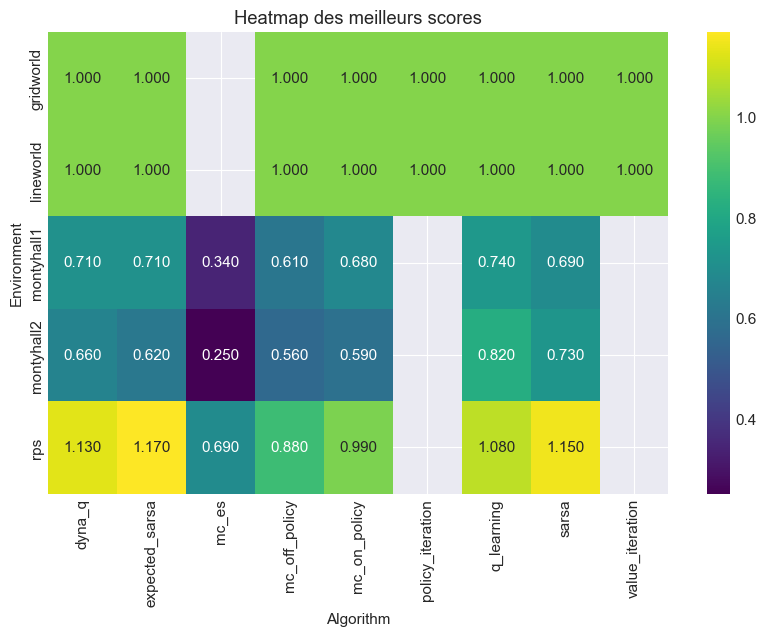

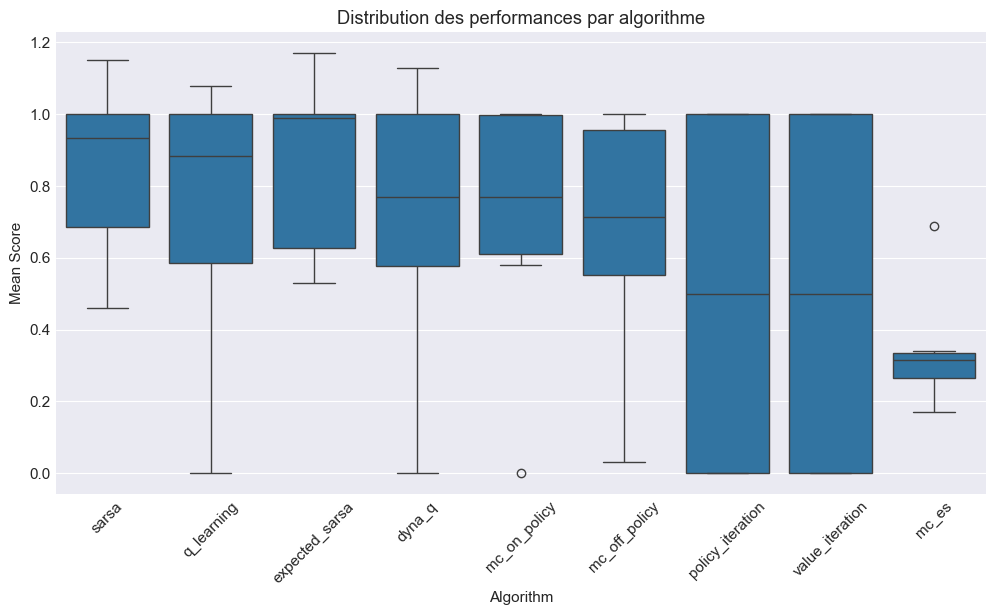

In [20]:
# =============================================================
# 🔍 GRID SEARCH ACROSS ALGOS × ENVS × HYPERPARAMÈTRES
# =============================================================
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

print("🔬 Lancement du grid search (cela peut être long)...")

param_grid = {
    # ----------------------------------------------------------
    # 1) Temporal‑Difference (TD) — α, γ, ε‑greedy
    # ----------------------------------------------------------
    'sarsa': {
        'alpha':          [0.1, 0.5],
        'gamma':          [0.9, 1.0],
        'epsilon_start':  [1.0],
        'epsilon_min':    [0.01],
        'epsilon_decay':  [0.995]
    },
    'q_learning': {
        'alpha':          [0.1, 0.5],
        'gamma':          [0.9, 1.0],
        'epsilon_start':  [1.0],
        'epsilon_min':    [0.01],
        'epsilon_decay':  [0.995]
    },
    'expected_sarsa': {
        'alpha':          [0.1, 0.5],
        'gamma':          [0.9, 1.0],
        'epsilon_start':  [1.0],
        'epsilon_min':    [0.01],
        'epsilon_decay':  [0.995]
    },

    # ----------------------------------------------------------
    # 2) Planning — Dyna‑Q (α, γ, ε‑greedy, planning steps)
    # ----------------------------------------------------------
    'dyna_q': {
        'alpha':              [0.1, 0.5],
        'gamma':              [0.9, 1.0],
        'n_planning_steps':   [10, 50],
        'epsilon_start':      [1.0],
        'epsilon_min':        [0.01],
        'epsilon_decay':      [0.995]
    },

    # ----------------------------------------------------------
    # 3) Monte‑Carlo
    #    - On‑policy : γ + ε‑greedy
    #    - Off‑policy / ES : γ seulement
    # ----------------------------------------------------------
    'mc_on_policy': {
        'gamma':          [0.9, 1.0],
        'epsilon_start':  [1.0],
        'epsilon_min':    [0.05],
        'epsilon_decay':  [0.995]
    },
    'mc_off_policy': {
        'gamma':          [0.9, 1.0]
    },
    'mc_es': {
        'gamma':          [0.9, 1.0]
    },

    # ----------------------------------------------------------
    # 4) Dynamic Programming (modèle connu)
    #    - Seul hyperparamètre utile : γ
    # ----------------------------------------------------------
    'policy_iteration': {
        'gamma':          [0.9, 1.0]   # (theta fixe dans runner.default_params)
    },
    'value_iteration': {
        'gamma':          [0.9, 1.0]   # (theta & max_iter restent par défaut)
    }
}
environments = ['lineworld', 'gridworld', 'rps', 'montyhall1', 'montyhall2']
algorithms = list(param_grid.keys())

grid_results = []

for env_name in tqdm(environments, desc="🌍 Environnements"):
    for algo_name in tqdm(algorithms, desc=f"🤖 Algo ({env_name})", leave=False):
        if algo_name == 'mc_es' and env_name in ['lineworld', 'gridworld']:
            continue
        if algo_name in ['policy_iteration', 'value_iteration'] and env_name in ['rps', 'montyhall1', 'montyhall2']:
            continue

        grid = param_grid[algo_name]
        if grid:
            keys = list(grid.keys())
            for values in product(*grid.values()):
                hp = dict(zip(keys, values))
                params = runner.default_params.copy()
                params.update(hp)
                if algo_name in ['policy_iteration', 'value_iteration']:
                    params['num_episodes'] = 1
                elif algo_name == 'dyna_q':
                    params.setdefault('num_episodes', 500)

                res = runner.run_experiment(env_name, algo_name, params)
                grid_results.append({
                    'Environment': env_name,
                    'Algorithm': algo_name,
                    **hp,
                    'Mean Score': res['mean_score'],
                    'Std Score': res['std_score'],
                    'Training Time': res['training_time']
                })
        else:
            params = runner.default_params.copy()
            if algo_name in ['policy_iteration', 'value_iteration']:
                params['num_episodes'] = 1
            elif algo_name == 'dyna_q':
                params.setdefault('num_episodes', 500)
            res = runner.run_experiment(env_name, algo_name, params)
            grid_results.append({
                'Environment': env_name,
                'Algorithm': algo_name,
                'Mean Score': res['mean_score'],
                'Std Score': res['std_score'],
                'Training Time': res['training_time']
            })

grid_df = pd.DataFrame(grid_results)
display(grid_df.head())

best_rows = (grid_df.sort_values('Mean Score', ascending=False)
                     .groupby(['Environment', 'Algorithm'])
                     .head(1)
                     .reset_index(drop=True))
display(best_rows)

pivot_best = best_rows.pivot(index='Environment', columns='Algorithm', values='Mean Score')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_best, annot=True, fmt=".3f", cmap='viridis')
plt.title("Heatmap des meilleurs scores")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=grid_df, x='Algorithm', y='Mean Score')
plt.xticks(rotation=45)
plt.title("Distribution des performances par algorithme")
plt.show()

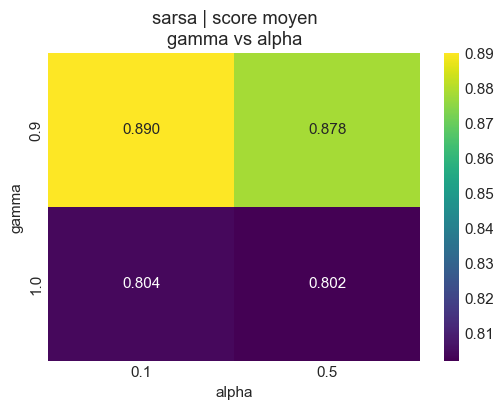

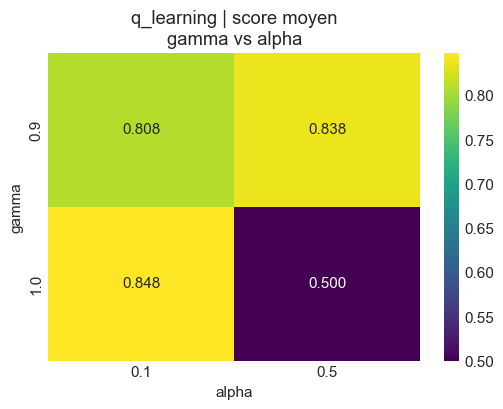

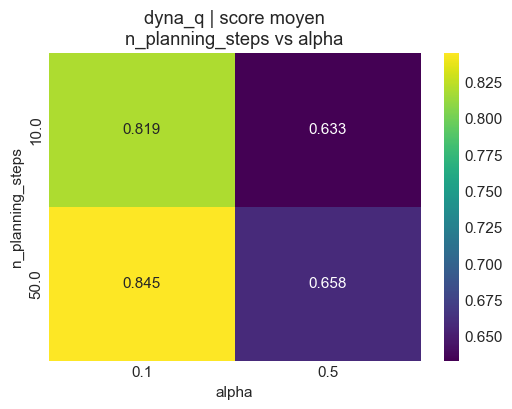

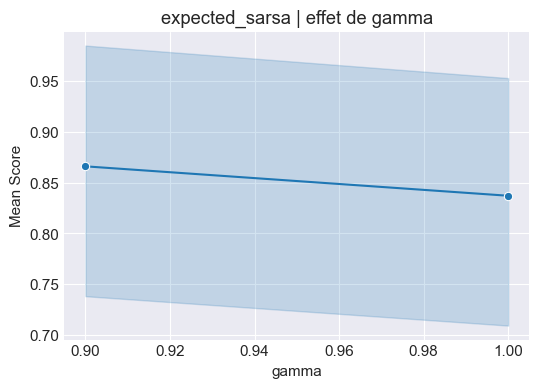

In [21]:
# =============================================================
# 🎨 ANALYSE VISUELLE DES HYPERPARAMÈTRES
# =============================================================
import seaborn as sns
import matplotlib.pyplot as plt

# --- Fonction utilitaire : heatmap 2‑D si deux hyperparams ---
def plot_heatmap(df, algo, x_param, y_param):
    pivot = (df[df['Algorithm'] == algo]
             .pivot_table(index=y_param, columns=x_param, values='Mean Score', aggfunc='mean'))
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
    plt.title(f"{algo} | score moyen\n{y_param} vs {x_param}")
    plt.show()

# === 2‑A) Heatmaps pour SARSA et Q‑Learning (alpha × gamma) ===
for algo in ['sarsa', 'q_learning']:
    if algo in grid_df['Algorithm'].unique():
        plot_heatmap(grid_df, algo, 'alpha', 'gamma')

# === 2‑B) Heatmap Dyna‑Q (n_planning_steps × alpha) ===
if 'dyna_q' in grid_df['Algorithm'].unique():
    plot_heatmap(grid_df, 'dyna_q', 'alpha', 'n_planning_steps')

# === 2‑C) Courbes 1‑D quand il y a plus d'un paramètre ===
# Ex. Expected SARSA: Mean Score vs gamma
for algo in ['expected_sarsa']:
    if algo in grid_df['Algorithm'].unique():
        plt.figure(figsize=(6,4))
        sns.lineplot(data=grid_df[grid_df['Algorithm']==algo],
                     x='gamma', y='Mean Score', marker='o')
        plt.title(f"{algo} | effet de gamma")
        plt.show()


In [22]:
print("🏆 Hyperparamètres optimaux par (Algo, Env) :")
best = (grid_df.sort_values('Mean Score', ascending=False)
                .groupby(['Algorithm', 'Environment'])
                .first()[['Mean Score','alpha','gamma','epsilon_start',
                          'epsilon_min','epsilon_decay','n_planning_steps']])
display(best)


🏆 Hyperparamètres optimaux par (Algo, Env) :


Mean Score  alpha  gamma  epsilon_start  \
Algorithm        Environment                                            
dyna_q           gridworld          1.00    0.1    0.9            1.0   
                 lineworld          1.00    0.1    0.9            1.0   
                 montyhall1         0.71    0.5    0.9            1.0   
                 montyhall2         0.66    0.1    1.0            1.0   
                 rps                1.13    0.5    1.0            1.0   
expected_sarsa   gridworld          1.00    0.1    0.9            1.0   
                 lineworld          1.00    0.5    0.9            1.0   
                 montyhall1         0.71    0.5    0.9            1.0   
                 montyhall2         0.62    0.5    0.9            1.0   
                 rps                1.17    0.5    0.9            1.0   
mc_es            montyhall1         0.34    NaN    0.9            NaN   
                 montyhall2         0.25    NaN    1.0            NaN   
                 rps                0.69    NaN    1.0            NaN   
mc_off_policy    gridworld          1.00    NaN    0.9            NaN   
                 lineworld          1.00    NaN    1.0            NaN   
                 montyhall1         0.61    NaN    0.9            NaN   
                 montyhall2         0.56    NaN    1.0            NaN   
                 rps                0.88    NaN    0.9            NaN   
mc_on_policy     gridworld          1.00    NaN    0.9            1.0   
                 lineworld          1.00    NaN    1.0            1.0   
                 montyhall1         0.68    NaN    1.0            1.0   
                 montyhall2         0.59    NaN    0.9            1.0   
                 rps                0.99    NaN    1.0            1.0   
policy_iteration gridworld          1.00    NaN    0.9            NaN   
                 lineworld          1.00    NaN    0.9            NaN   
q_learning       gridworld          1.00    0.5    0.9            1.0   
                 lineworld          1.00    0.1    1.0            1.0   
                 montyhall1         0.74    0.1    1.0            1.0   
                 montyhall2         0.82    0.5    1.0            1.0   
                 rps                1.08    0.1    1.0            1.0   
sarsa            gridworld          1.00    0.1    1.0            1.0   
                 lineworld          1.00    0.1    1.0            1.0   
                 montyhall1         0.69    0.5    0.9            1.0   
                 montyhall2         0.73    0.5    0.9            1.0   
                 rps                1.15    0.1    0.9            1.0   
value_iteration  gridworld          1.00    NaN    0.9            NaN   
                 lineworld          1.00    NaN    0.9            NaN   

                              epsilon_min  epsilon_decay  n_planning_steps  
Algorithm        Environment                                                
dyna_q           gridworld           0.01          0.995              50.0  
                 lineworld           0.01          0.995              10.0  
                 montyhall1          0.01          0.995              50.0  
                 montyhall2          0.01          0.995              50.0  
                 rps                 0.01          0.995              50.0  
expected_sarsa   gridworld           0.01          0.995               NaN  
                 lineworld           0.01          0.995               NaN  
                 montyhall1          0.01          0.995               NaN  
                 montyhall2          0.01          0.995               NaN  
                 rps                 0.01          0.995               NaN  
mc_es            montyhall1           NaN            NaN               NaN  
                 montyhall2           NaN            NaN               NaN  
                 rps                  NaN            NaN               NaN  
mc_off_policy    gridworld 

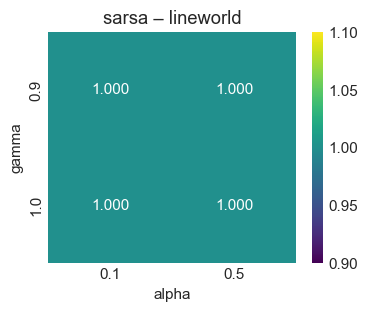

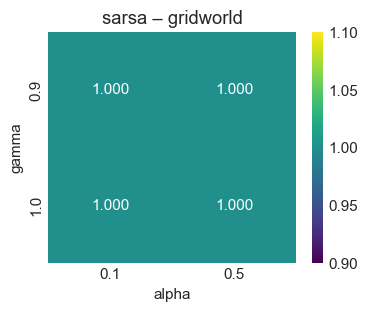

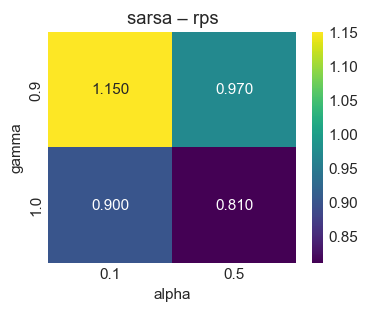

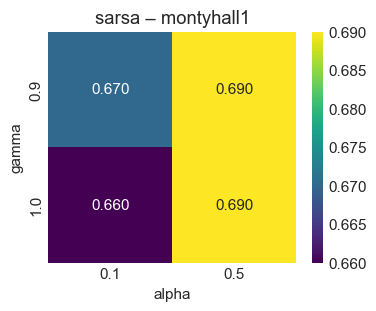

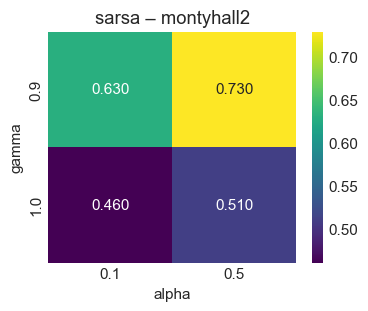

In [23]:
import seaborn as sns, matplotlib.pyplot as plt

def heatmap_param(df, algo, env, x='alpha', y='gamma'):
    subset = df[(df.Algorithm == algo) & (df.Environment == env)]
    piv = subset.pivot_table(index=y, columns=x, values='Mean Score', aggfunc='mean')
    plt.figure(figsize=(4,3))
    sns.heatmap(piv, annot=True, fmt='.3f', cmap='viridis')
    plt.title(f'{algo} – {env}')
    plt.show()

for env in ['lineworld', 'gridworld', 'rps', 'montyhall1', 'montyhall2']:
    heatmap_param(grid_df, 'sarsa', env)
